- Import Packages

In [164]:
import torch
import torch.nn as nn
import numpy as np
from mkit.torch_support.nn_utils import training_loop
from mkit.torch_support.tensor_utils import xy_to_tensordataset, one_cut_split, sequential_x_y_split
from mkit.torch_support.predict import autoregressive
from mkit.torch_support.model.RNN import StackedResidualIndRNN
from mkit.torch_support.dummy_dataset import DummySequentialData
from mkit.preprocess.transform import MinMaxScaler
import matplotlib.pyplot as plt

- Data Generation

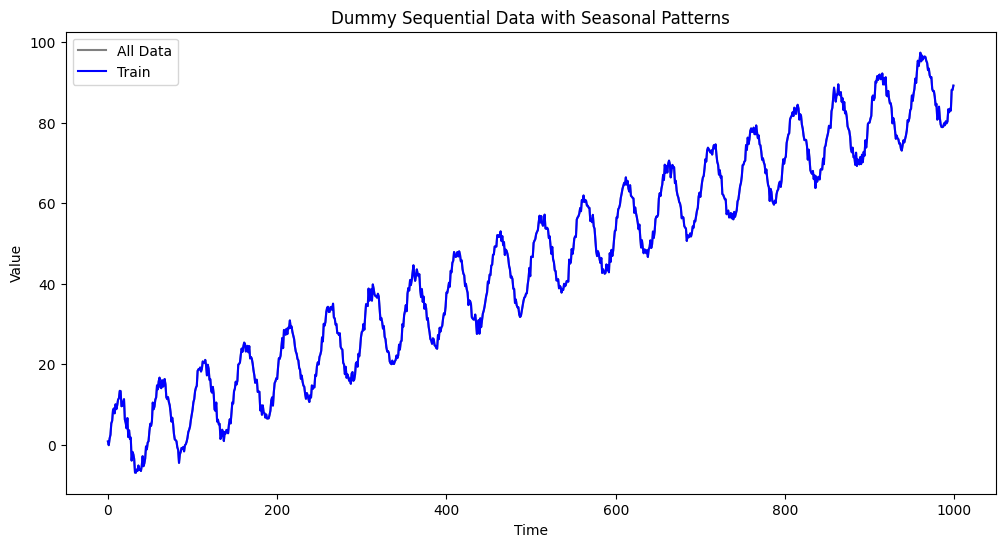

In [165]:
LOOK_BACK = 100
data = DummySequentialData(trend=.09)
transformer = MinMaxScaler()
data.plot_data()

- Data Splitting

In [166]:

train, val, test = one_cut_split(data.data, val_split=.2, test_split=.2)
train_transformed = transformer.fit_transform(train)
train_x, train_y = sequential_x_y_split(train_transformed, look_back=LOOK_BACK)
val_transformed = transformer.transform(val)
val_x, val_y = sequential_x_y_split(val_transformed, look_back=LOOK_BACK)

In [167]:
train_x.shape, train_y.shape

((540, 100), (540,))

In [168]:
train_x.shape

(540, 100)

- Data Preprocessing

In [169]:

train_loader = xy_to_tensordataset(
    train_x, train_y, 
    return_loader=True, 
    unsqueeze_last=True,
    input_dtype=torch.float,
    output_dtype=torch.float
)
val_loader = xy_to_tensordataset(
    val_x, 
    val_y, 
    return_loader=True, 
    unsqueeze_last=True # for regression task, the last dim needs to be one
) 

- Module Construction

In [170]:
class NN(nn.Module):
    def __init__(
            self,
            hidden_dims = [],
            output_dim = None,
            device = torch.device('cpu')
            ):
        super().__init__()
        if output_dim is None or len(hidden_dims) < 2: raise ValueError("Invalid Arguments") 
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        
        self.net = nn.ModuleList()
        
        for i in range(len(hidden_dims) - 1):
            self.net.append(nn.Linear(hidden_dims[i], hidden_dims[i + 1]))
            self.net.append(nn.ReLU())
        self.net.append(nn.Linear(hidden_dims[-1], output_dim))
        self.net = nn.Sequential(*self.net)
        self.device = device
        self.to(device)
    def forward(self, x):
        x = x.to(self.device).float()
        batch, _, _ = x.shape
        x = x.view(batch, -1)
        # print(x.shape)
        out = self.net(x)
        return out
    

In [171]:


device = torch.device('cuda')
model = NN(
    hidden_dims=[train_x.shape[1], 16, 32], 
    output_dim=1,
    device=device
)

In [172]:
model, train_losses, val_losses = training_loop(
    model=model,
    device=device,
    criterion=nn.MSELoss(),
    epochs=20,
    train_loader=train_loader,
    optimizer=torch.optim.Adam(model.parameters()),
    val_loader=val_loader,
    keep_losses=True
)

EPOCH 1/20: 100%|██████████| 17/17 [00:00<00:00, 162.01it/s]


Epoch [1/20] Training Loss: 0.0652  Validation Loss: 0.0171



EPOCH 2/20: 100%|██████████| 17/17 [00:00<00:00, 190.89it/s]


Epoch [2/20] Training Loss: 0.0162  Validation Loss: 0.0330



EPOCH 3/20: 100%|██████████| 17/17 [00:00<00:00, 180.62it/s]


Epoch [3/20] Training Loss: 0.0114  Validation Loss: 0.0228



EPOCH 4/20: 100%|██████████| 17/17 [00:00<00:00, 186.78it/s]


Epoch [4/20] Training Loss: 0.0095  Validation Loss: 0.0166



EPOCH 5/20: 100%|██████████| 17/17 [00:00<00:00, 203.84it/s]


Epoch [5/20] Training Loss: 0.0077  Validation Loss: 0.0127



EPOCH 6/20: 100%|██████████| 17/17 [00:00<00:00, 191.83it/s]


Epoch [6/20] Training Loss: 0.0060  Validation Loss: 0.0088



EPOCH 7/20: 100%|██████████| 17/17 [00:00<00:00, 199.54it/s]


Epoch [7/20] Training Loss: 0.0044  Validation Loss: 0.0083



EPOCH 8/20: 100%|██████████| 17/17 [00:00<00:00, 196.42it/s]


Epoch [8/20] Training Loss: 0.0029  Validation Loss: 0.0048



EPOCH 9/20: 100%|██████████| 17/17 [00:00<00:00, 194.92it/s]


Epoch [9/20] Training Loss: 0.0019  Validation Loss: 0.0021



EPOCH 10/20: 100%|██████████| 17/17 [00:00<00:00, 201.94it/s]


Epoch [10/20] Training Loss: 0.0011  Validation Loss: 0.0007



EPOCH 11/20: 100%|██████████| 17/17 [00:00<00:00, 197.93it/s]


Epoch [11/20] Training Loss: 0.0007  Validation Loss: 0.0011



EPOCH 12/20: 100%|██████████| 17/17 [00:00<00:00, 196.54it/s]


Epoch [12/20] Training Loss: 0.0005  Validation Loss: 0.0004



EPOCH 13/20: 100%|██████████| 17/17 [00:00<00:00, 200.19it/s]


Epoch [13/20] Training Loss: 0.0004  Validation Loss: 0.0002



EPOCH 14/20: 100%|██████████| 17/17 [00:00<00:00, 193.10it/s]


Epoch [14/20] Training Loss: 0.0003  Validation Loss: 0.0002



EPOCH 15/20: 100%|██████████| 17/17 [00:00<00:00, 184.91it/s]


Epoch [15/20] Training Loss: 0.0003  Validation Loss: 0.0003



EPOCH 16/20: 100%|██████████| 17/17 [00:00<00:00, 185.50it/s]


Epoch [16/20] Training Loss: 0.0003  Validation Loss: 0.0002



EPOCH 17/20: 100%|██████████| 17/17 [00:00<00:00, 196.07it/s]


Epoch [17/20] Training Loss: 0.0003  Validation Loss: 0.0002



EPOCH 18/20: 100%|██████████| 17/17 [00:00<00:00, 183.49it/s]


Epoch [18/20] Training Loss: 0.0003  Validation Loss: 0.0002



EPOCH 19/20: 100%|██████████| 17/17 [00:00<00:00, 169.44it/s]


Epoch [19/20] Training Loss: 0.0003  Validation Loss: 0.0002



EPOCH 20/20: 100%|██████████| 17/17 [00:00<00:00, 207.93it/s]

Epoch [20/20] Training Loss: 0.0003  Validation Loss: 0.0002

Training complete.


## Prediction and Evaluation

- Time-series Non-autoregressive

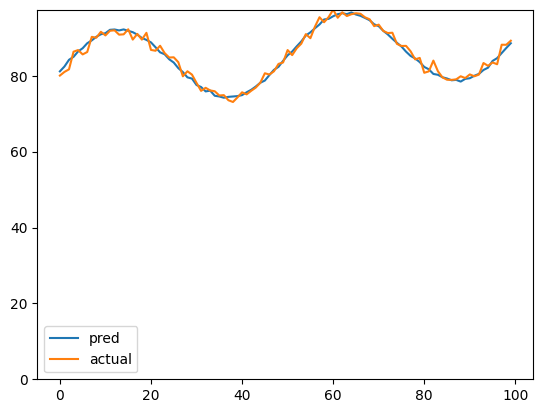

In [173]:


test_x, test_y = sequential_x_y_split(test, look_back=LOOK_BACK)
model.to(device)
with torch.no_grad():
    pred = model(torch.tensor(transformer.transform(test_x), dtype=torch.float, device=device).unsqueeze(-1)).detach().cpu()
    pred = transformer.inverse_transform(pred).detach().cpu().squeeze(-1).numpy()
plt.plot(pred, label='pred')
plt.plot(test_y, label='actual')
plt.ylim(0, np.max([pred, test_y]))
plt.legend()

- Autoregressive

In [174]:
result = autoregressive(
    x=train_x[-1], 
    model=model,
    steps_ahead=len(test), 
    device=torch.device('cuda')
)

100%|██████████| 200/200 [00:00<00:00, 859.15it/s]

Autoregressive Prediction Completed🚀


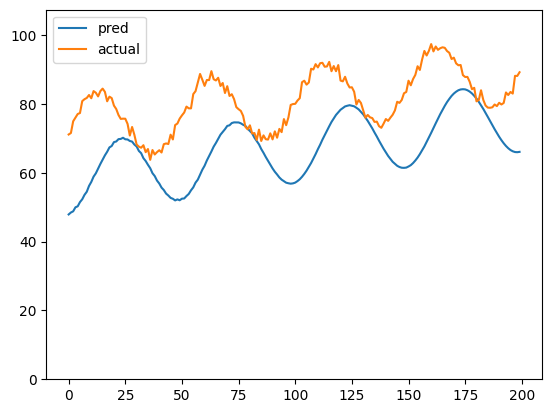

In [175]:
pred_a = transformer.inverse_transform(result.cpu().detach().numpy())
plt.ylim(0, np.max([pred_a, test]) + 10)
plt.plot(pred_a, label='pred')
plt.plot(test, label='actual')
plt.legend()
plt.show()

net.0.weight: torch.Size([16, 100])
net.2.weight: torch.Size([32, 16])
net.4.weight: torch.Size([1, 32])


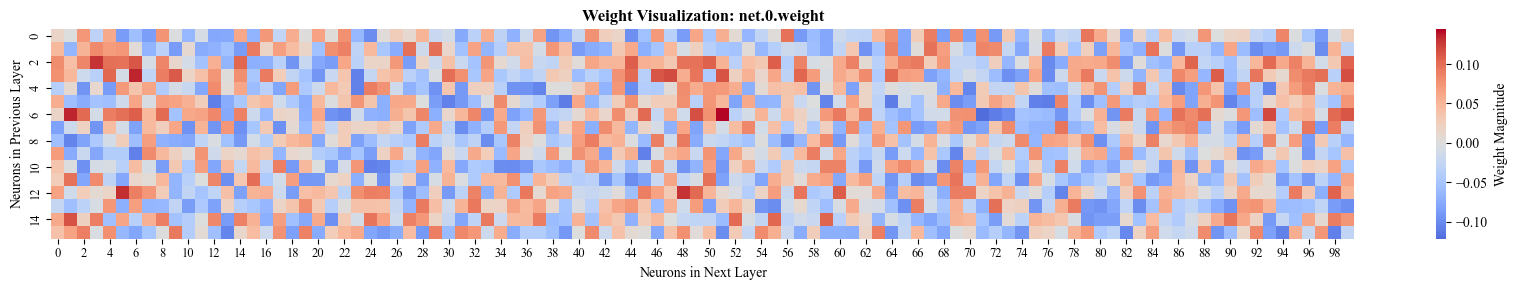

net.0.weight: torch.Size([16, 100])
net.2.weight: torch.Size([32, 16])
net.4.weight: torch.Size([1, 32])


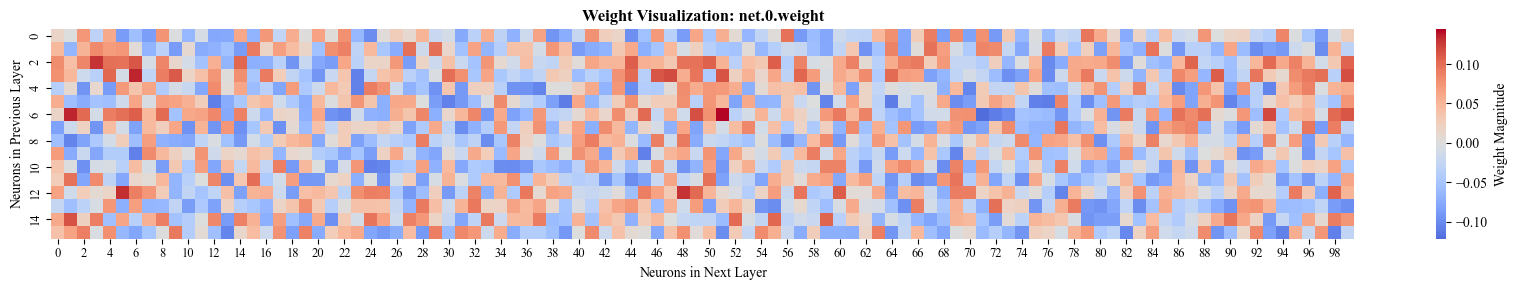

net.0.weight: torch.Size([16, 100])
net.2.weight: torch.Size([32, 16])
net.4.weight: torch.Size([1, 32])


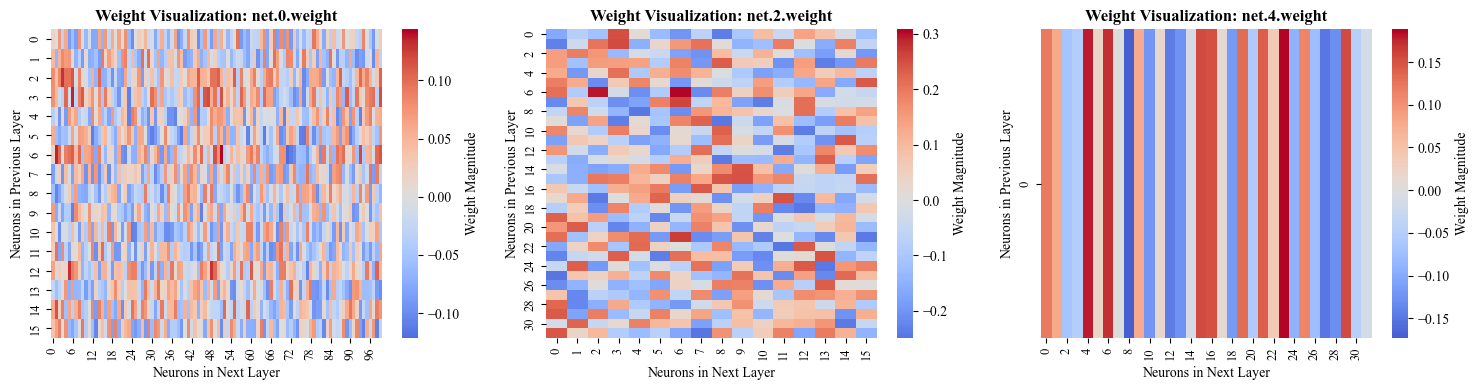

In [225]:


# Example Usage:
# Visualize the first weight layer
visualize_weights_or_biases(model, layer_index=0, param_type="weight")

# Visualize the second weight layer
visualize_weights_or_biases(model, layer_index=0, param_type="weight")

# Visualize all weight layers
visualize_weights_or_biases(model, layer_index="all", param_type="weight")
